In [1]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neural_network import MLPRegressor
import os
import iris
import numpy as np
import seaborn as sns
from GridcellDataset import GridcellDataset
from pathos.multiprocessing import Pool
from matplotlib import pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

In [2]:
def plot(df, label=None, vmin=None, vmax=None):
    plt.close('all')
    fig = plt.figure(figsize=(18,1))

    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)

    im = ax1.pcolormesh(df['target'].unstack().values, vmin=vmin, vmax=vmax)
    ax2.pcolormesh(df['preds'].unstack().values, vmin=vmin, vmax=vmax)
    ax3.pcolormesh(df['stratiform_rainfall_amount'].unstack().values, vmin=vmin, vmax=vmax)
    
    ax1.set_title('target')
    ax1.set_ylabel(label)
    ax2.set_title('model')
    ax3.set_title('baseline')

    fig.subplots_adjust(right=0.82)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(im, cax=cbar_ax);

In [3]:
coord_system = iris.coord_systems.RotatedGeogCS(37.5, 177.5, 
                                                ellipsoid=iris.coord_systems.GeogCS(6371229.0)).as_cartopy_crs()

def transform(lon, lat):
    return coord_system.transform_point(lon, lat, ccrs.PlateCarree())

In [160]:
train_dfs = []
test_dfs = []
models = []
for i in [2,4,8]:
    train = pd.read_csv('/dev/data/train{:d}.csv'.format(i))
    t = ['target', 'stratiform_rainfall_amount', 'stratiform_rainfall_amount_up',
         'stratiform_rainfall_amount_down', 'stratiform_rainfall_amount_left', 'stratiform_rainfall_amount_right'] 
    train[t] = np.log1p(train[t])
    
    rf = RandomForestRegressor(n_estimators=20, max_features='sqrt', n_jobs=1)
    X = train[train.columns.difference(['Unnamed: 0', 'target'])]
    y = train['target']
    rf.fit(X, y)
    
    test = pd.read_csv('/dev/data/test{:d}.csv'.format(i))
    test[t[1:]] = np.log1p(test[t[1:]])
    Xt = test[test.columns.difference(['Unnamed: 0', 'target'])]
    yt = test['target']
    preds = rf.predict(Xt)
    test['preds'] = np.expm1(preds)
    
    test['proj'] = test.apply(lambda x: transform(x['longitude'], x['latitude']), axis=1)
    test['lon'] = test.apply(lambda x: x['proj'][0], axis=1)
    test['lat'] = test.apply(lambda x: x['proj'][1], axis=1)
    
    train_dfs.append(train)
    test_dfs.append(test)
    models.append(rf)

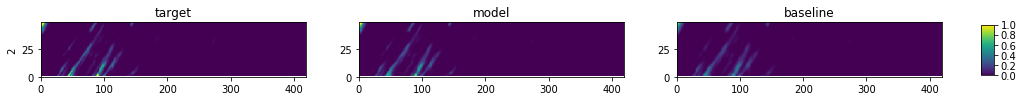

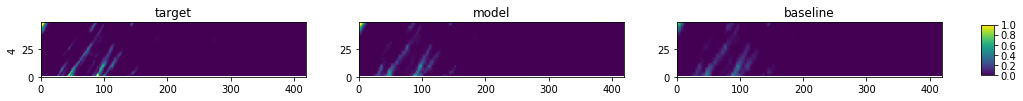

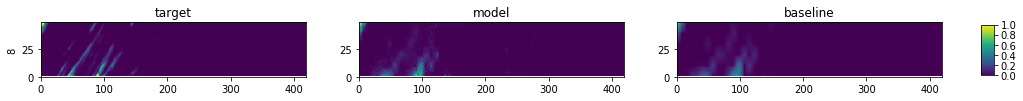

In [172]:
vmin = np.min(np.array([df[['target', 'preds', 'stratiform_rainfall_amount']].values for df in test_dfs]))
vmax = np.max(np.array([df[['target', 'preds', 'stratiform_rainfall_amount']].values for df in test_dfs]))

for i, test in enumerate(test_dfs):
    tstep = test[test['DOY'] == 173]
    means = tstep.groupby([pd.cut(tstep['lat'], np.arange(2, 3, 0.02)), 
                          pd.cut(tstep['lon'], np.arange(-5.1, 3.3, 0.02))]).mean()
    
    plot(means, vmin=0, vmax=1, label=str([2,4,8][i]))
    plt.show()

In [162]:
np.unique(test_dfs[0]['DOY'])

array([173, 203, 228, 231, 234])

In [163]:
cols = train_dfs[0].columns.difference(['Unnamed: 0', 'target'])

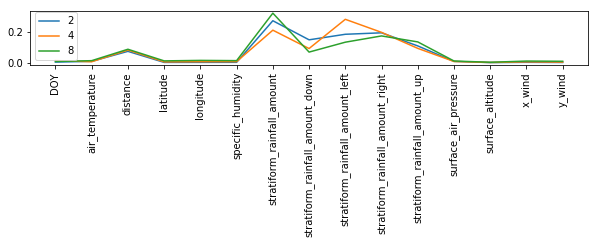

In [164]:
plt.figure(figsize=(10,1))
for i, m in enumerate(models):
    plt.plot(range(len(cols)), m.feature_importances_, label=str([2,4,8][i]))
    plt.gca().set_xticks(range(len(cols)))
    plt.gca().set_xticklabels(cols, rotation='vertical')
    plt.legend()

In [165]:
testset = test_dfs[0]

In [166]:
testset = testset[testset.columns.difference(['Unnamed: 0', 'target', 'proj', 'lat', 'lon', 'preds'])]

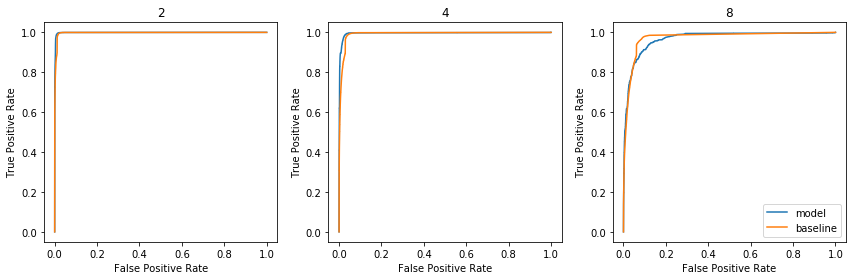

In [167]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
for i, m in enumerate(models):
    yhat = m.predict(testset)
    true = (test_dfs[0]['target'] > 0).astype(int)
    fpr, tpr, _ = sklearn.metrics.roc_curve(true, yhat)
    ax[i].plot(fpr, tpr, label='model')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
for j, t in enumerate(test_dfs):
    yhat = t['stratiform_rainfall_amount']
    true = (t['target'] > 0).astype(int)
    fpr, tpr, _ = sklearn.metrics.roc_curve(true, yhat)
    ax[j].plot(fpr, tpr, label='baseline')
    ax[j].set_title([2,4,8][j])
    ax[j].set_xlabel('False Positive Rate')
    ax[j].set_ylabel('True Positive Rate')
plt.legend()
plt.tight_layout()

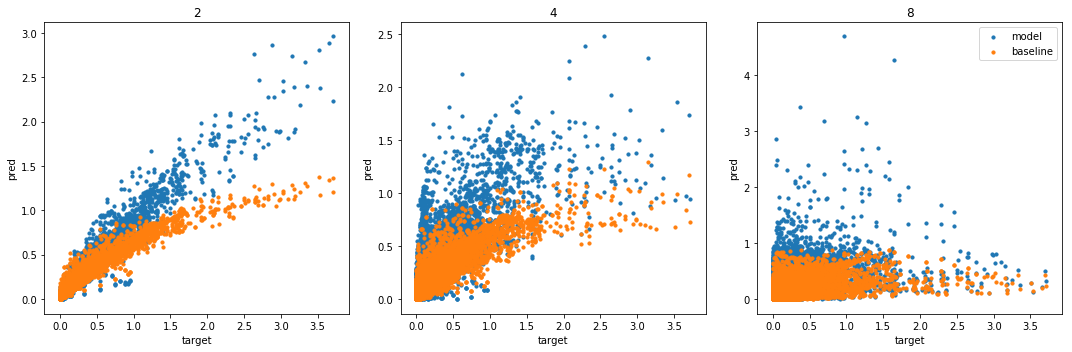

In [168]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, res in enumerate(test_dfs):
    yhat = res['preds']
    true = res['target']
    ax[i].scatter(true, yhat, s=10, label='model')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('target')
    ax[i].set_ylabel('pred')
# for i, res in enumerate(test_dfs):
    yhat = res['stratiform_rainfall_amount']
    true = res['target']
    ax[i].scatter(true, yhat, s=10, label='baseline')
    ax[i].set_title([2,4,8][i])
    ax[i].set_xlabel('target')
    ax[i].set_ylabel('pred')
plt.legend()
plt.tight_layout()

In [26]:
%%time
newtest2 = test = pd.read_csv('/dev/data/newtest2.csv')

CPU times: user 14.6 s, sys: 776 ms, total: 15.3 s
Wall time: 15.3 s


In [28]:
np.unique(newtest2['DOY'])

array([167, 170, 173, 197, 200, 203, 228, 231, 234])

In [36]:
422352 // 21

20112

In [146]:
i0=0; i1=1
tdf = newtest2.iloc[20112*i0:20112*i1].copy()

In [155]:
t = ['stratiform_rainfall_amount', 'stratiform_rainfall_amount_up',
     'stratiform_rainfall_amount_down', 'stratiform_rainfall_amount_left', 'stratiform_rainfall_amount_right'] 

i0=10; i1=11
tdf = newtest2.iloc[20112*i0:20112*i1].copy()

# print(tdf.iloc[1])
tdf[t] = np.log1p(tdf[t])
# print(tdf.iloc[1])

Xt = tdf[tdf.columns.difference(['Unnamed: 0', 'target'])]
yt = tdf['target']
preds = models[0].predict(Xt)
tdf['preds'] = np.expm1(preds)

tdf['proj'] = tdf.apply(lambda x: transform(x['longitude'], x['latitude']), axis=1)
tdf['lon'] = tdf.apply(lambda x: x['proj'][0], axis=1)
tdf['lat'] = tdf.apply(lambda x: x['proj'][1], axis=1)

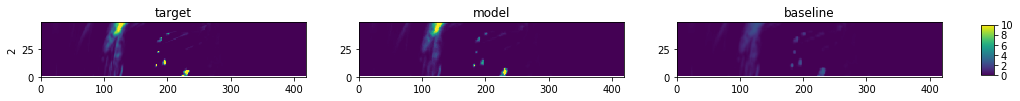

In [157]:
tdfm = tdf.groupby([pd.cut(tdf['lat'], np.arange(2, 3, 0.02)), 
                    pd.cut(tdf['lon'], np.arange(-5.1, 3.3, 0.02))]).mean()
plot(tdfm, vmin=0, vmax=10, label=i)

In [158]:
%%time
trainset = train_dfs[0].copy()

trainset['proj'] = trainset.apply(lambda x: transform(x['longitude'], x['latitude']), axis=1)
trainset['lon'] = trainset.apply(lambda x: x['proj'][0], axis=1)
trainset['lat'] = trainset.apply(lambda x: x['proj'][1], axis=1)

KeyboardInterrupt: 

In [159]:
means = trainset.groupby([pd.cut(trainset['lat'], np.arange(2, 3, 0.02)), 
                          pd.cut(trainset['lon'], np.arange(-5.1, 3.3, 0.02))]).max()

KeyError: 'lat'

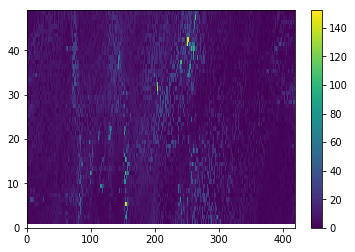

In [10]:
plt.pcolormesh(means['target'].unstack().values)
plt.colorbar()

(0, 1000)

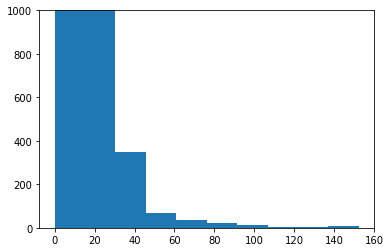

In [109]:
plt.hist(train_dfs[0]['target'])
plt.gca().set_ylim((0,1000))